# Kidney Stone Prediction Analysis

source from : https://www.kaggle.com/competitions/playground-series-s3e12/data

## EDA

In [3]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (414, 8)
The dimession of the test dataset is: (276, 7)


In [5]:
train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [6]:
train.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [8]:
test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [9]:
test.describe()

,id,gravity,ph,osmo,cond,urea,calc
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,551.500000,1.018330,5.939312,654.891304,21.886594,280.985507,4.076848
std,79.818544,0.006569,0.607143,236.361932,7.346069,134.877856,3.088524
min,414.000000,1.005000,4.900000,187.000000,5.100000,64.000000,0.170000
25%,482.750000,1.014000,5.530000,456.000000,17.400000,168.500000,1.527500
50%,551.500000,1.019000,5.730000,658.000000,23.600000,282.000000,3.230000
75%,620.250000,1.023250,6.210000,843.250000,27.600000,385.000000,5.540000
max,689.000000,1.034000,7.940000,1236.000000,38.000000,620.000000,14.340000


### Explanation of the data 

its new world for me , so i made a research on it , i get that


    id: id of the obsevation.
    gravity: specific gravity, the density of the urine relative to water.
    ph: he negative logarithm of the hydrogen ion.
    osmo: osmolarity. Osmolarity is proportional to the concentration of molecules in solution.
    cond: conductivity (mMho milliMho). One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged ions in solution.
    urea: urea concentration in millimoles per litre.
    calc: calcium concentration (CALC) in millimolesllitre.
    target: 0- absence of stone 1- presence of stone.


### Data Exploration

In [10]:
round(100*train['target'].value_counts() / train.shape[0], 2)

0    55.56
1    44.44
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='count'>

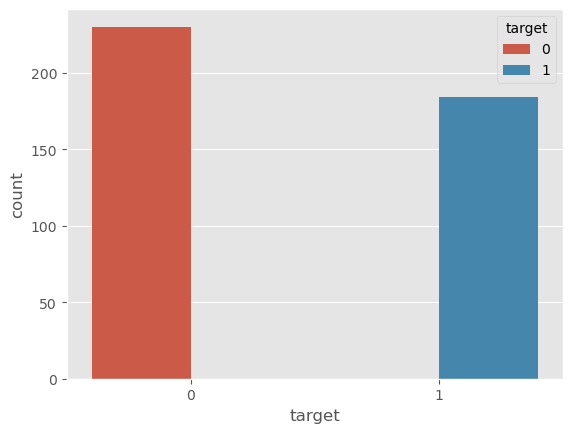

In [11]:
sns.countplot(x = 'target', hue = 'target', data = train)

the data seems pretty balanced

<AxesSubplot:xlabel='target', ylabel='ph'>

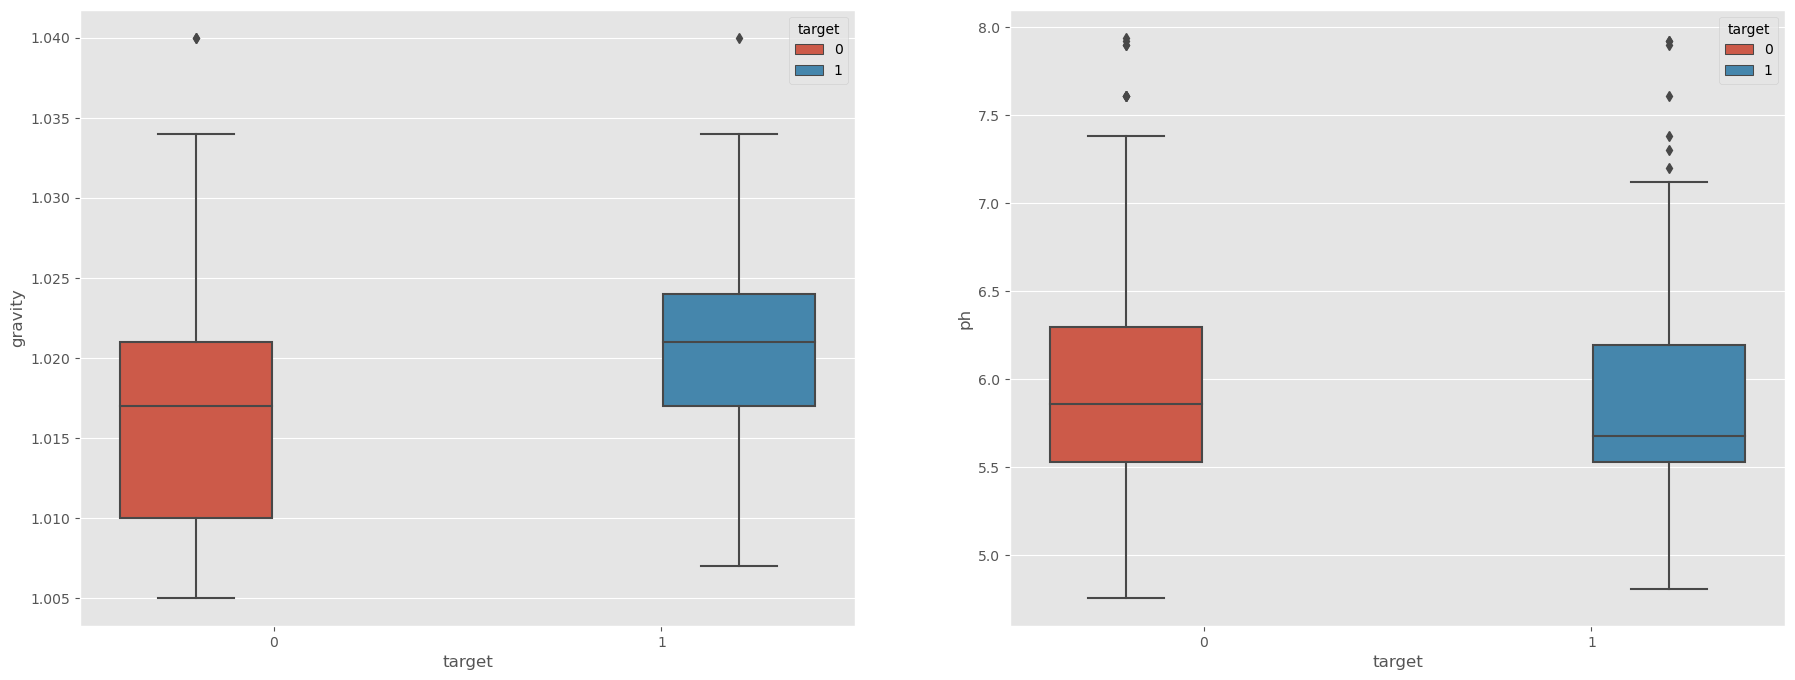

In [12]:


fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'gravity', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'ph', hue = 'target', data = train)

From the above boxplots, we see the median of target=1 of gravity is larger than target=0.

<AxesSubplot:xlabel='target', ylabel='cond'>

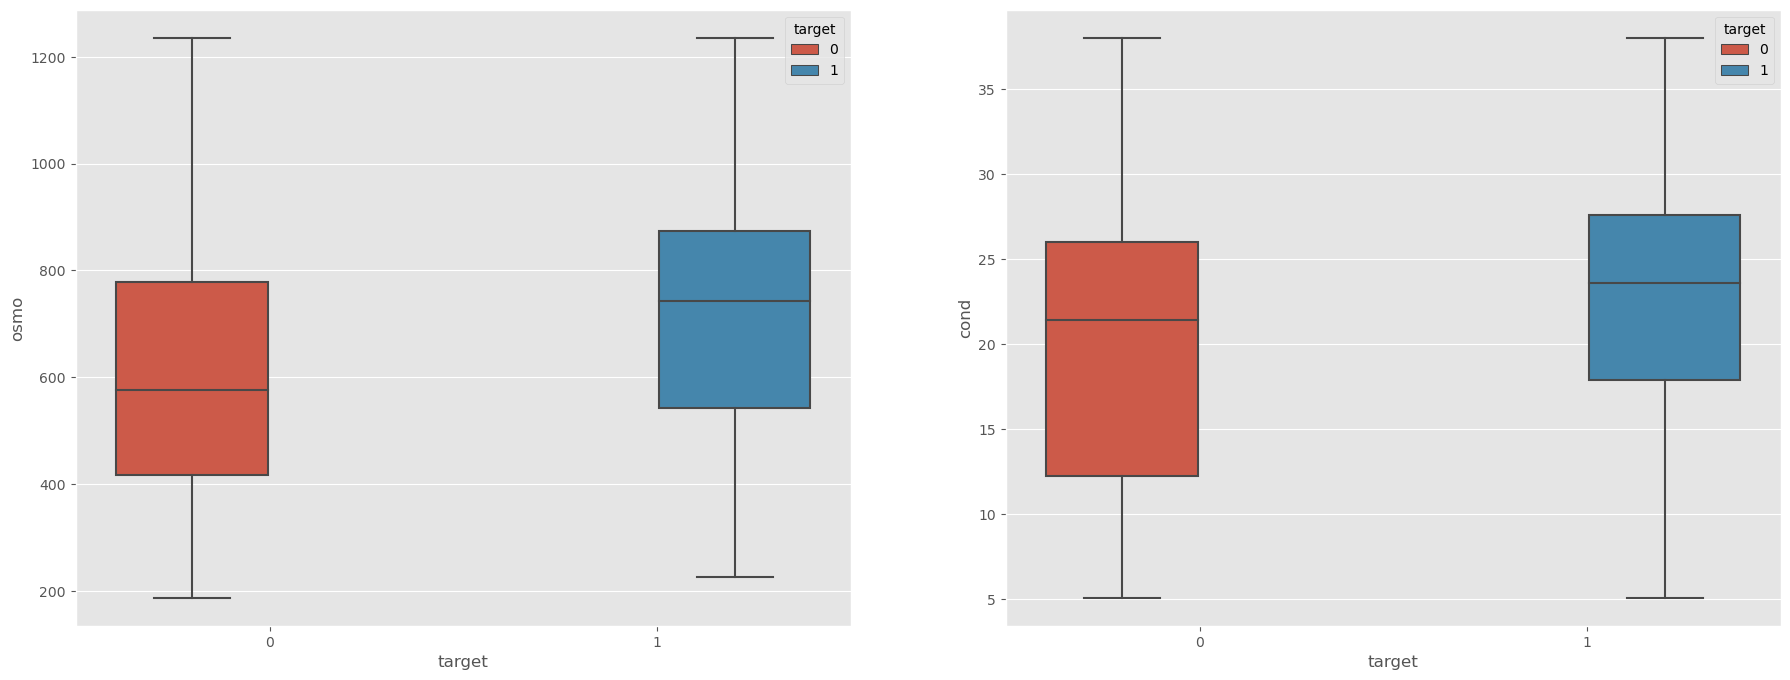

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'osmo', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'cond', hue = 'target', data = train)

In the left panel, we see the median of target=1 of osmo is larger than target=0. On the other hand, in the right panel, we see that the median of target=1 is slighlty larger than target=0 

<AxesSubplot:xlabel='target', ylabel='calc'>

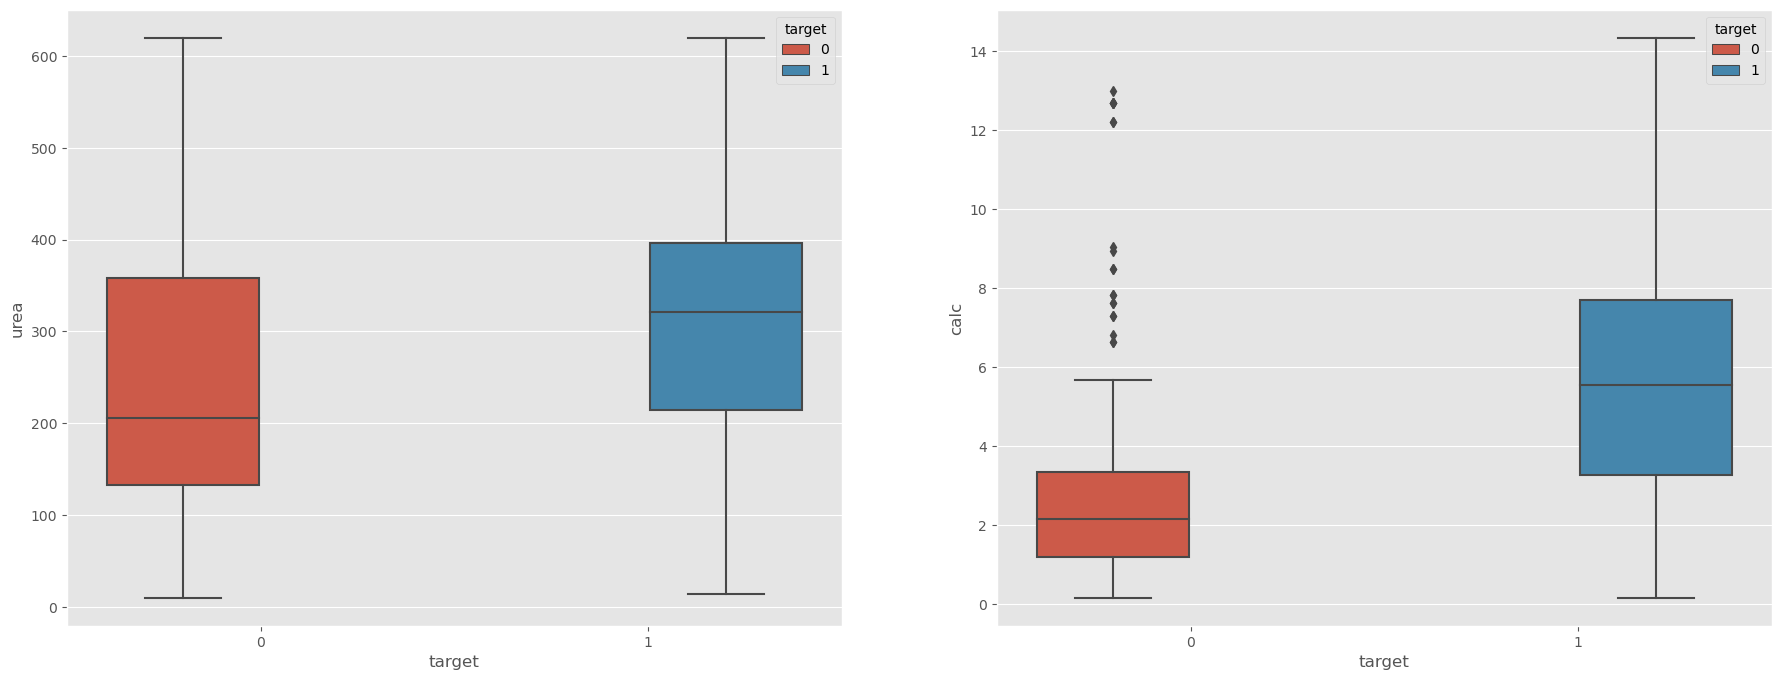

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'urea', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'calc', hue = 'target', data = train)

From the above boxplots, we see the median of target=1 of urea and calc is larger than target=0. 

Exploring the numerical value

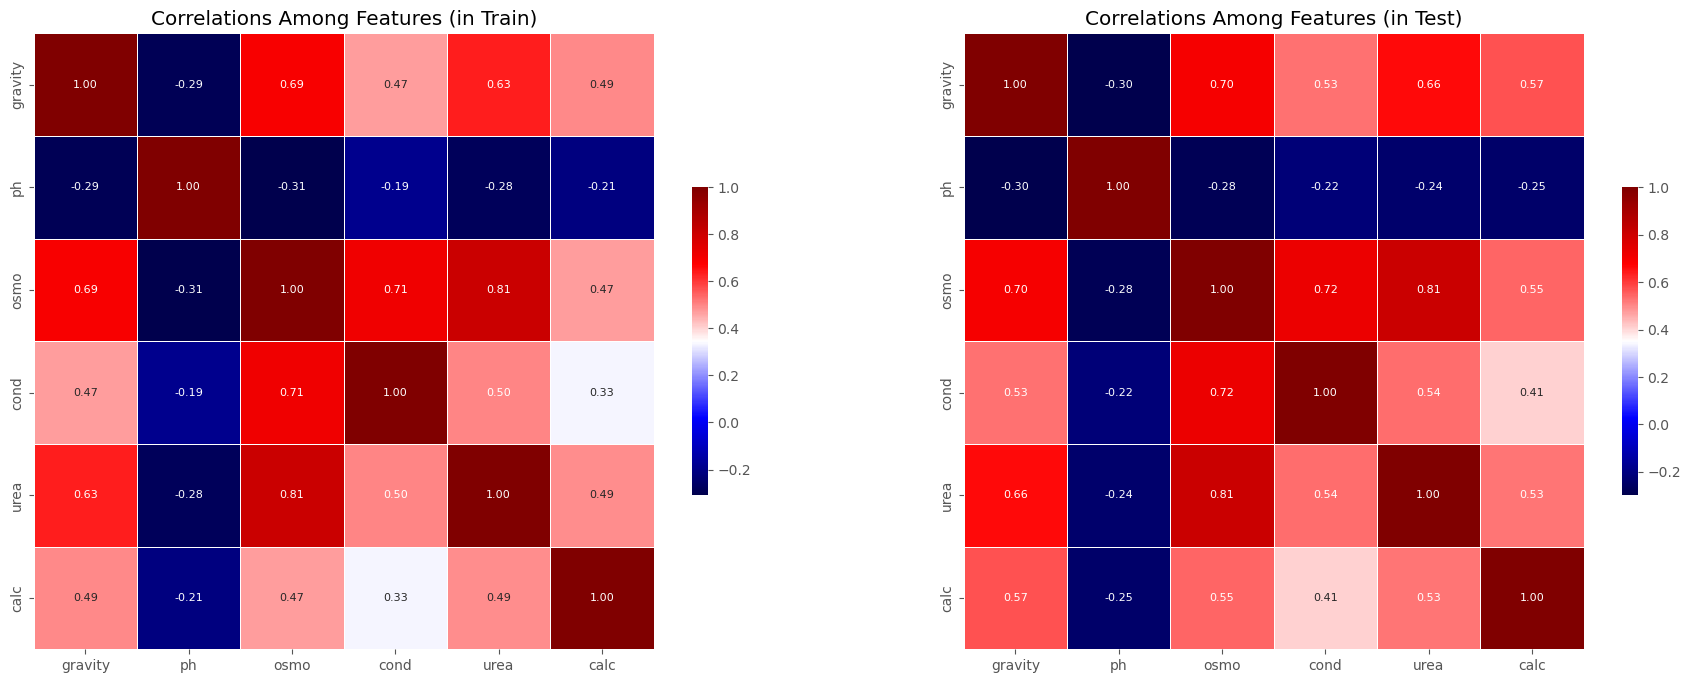

In [15]:
## Explore the correlation between all numerical features
corr_mat_train = train.drop(columns = ['id', 'target'], axis = 1).corr()
corr_mat_test = test.drop(columns = ['id'], axis = 1).corr()

## Keep only correlation higher than a threshold
threshold = 0.1
corr_threshold_train = corr_mat_train[(corr_mat_train > threshold) | (corr_mat_train < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]

fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(corr_threshold_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

From the above heatmaps, we see that the correlation among the features are almost the same in the train and test datasets.

compare the distribution of the features in the train and test datasets.

<AxesSubplot:xlabel='calc', ylabel='Density'>

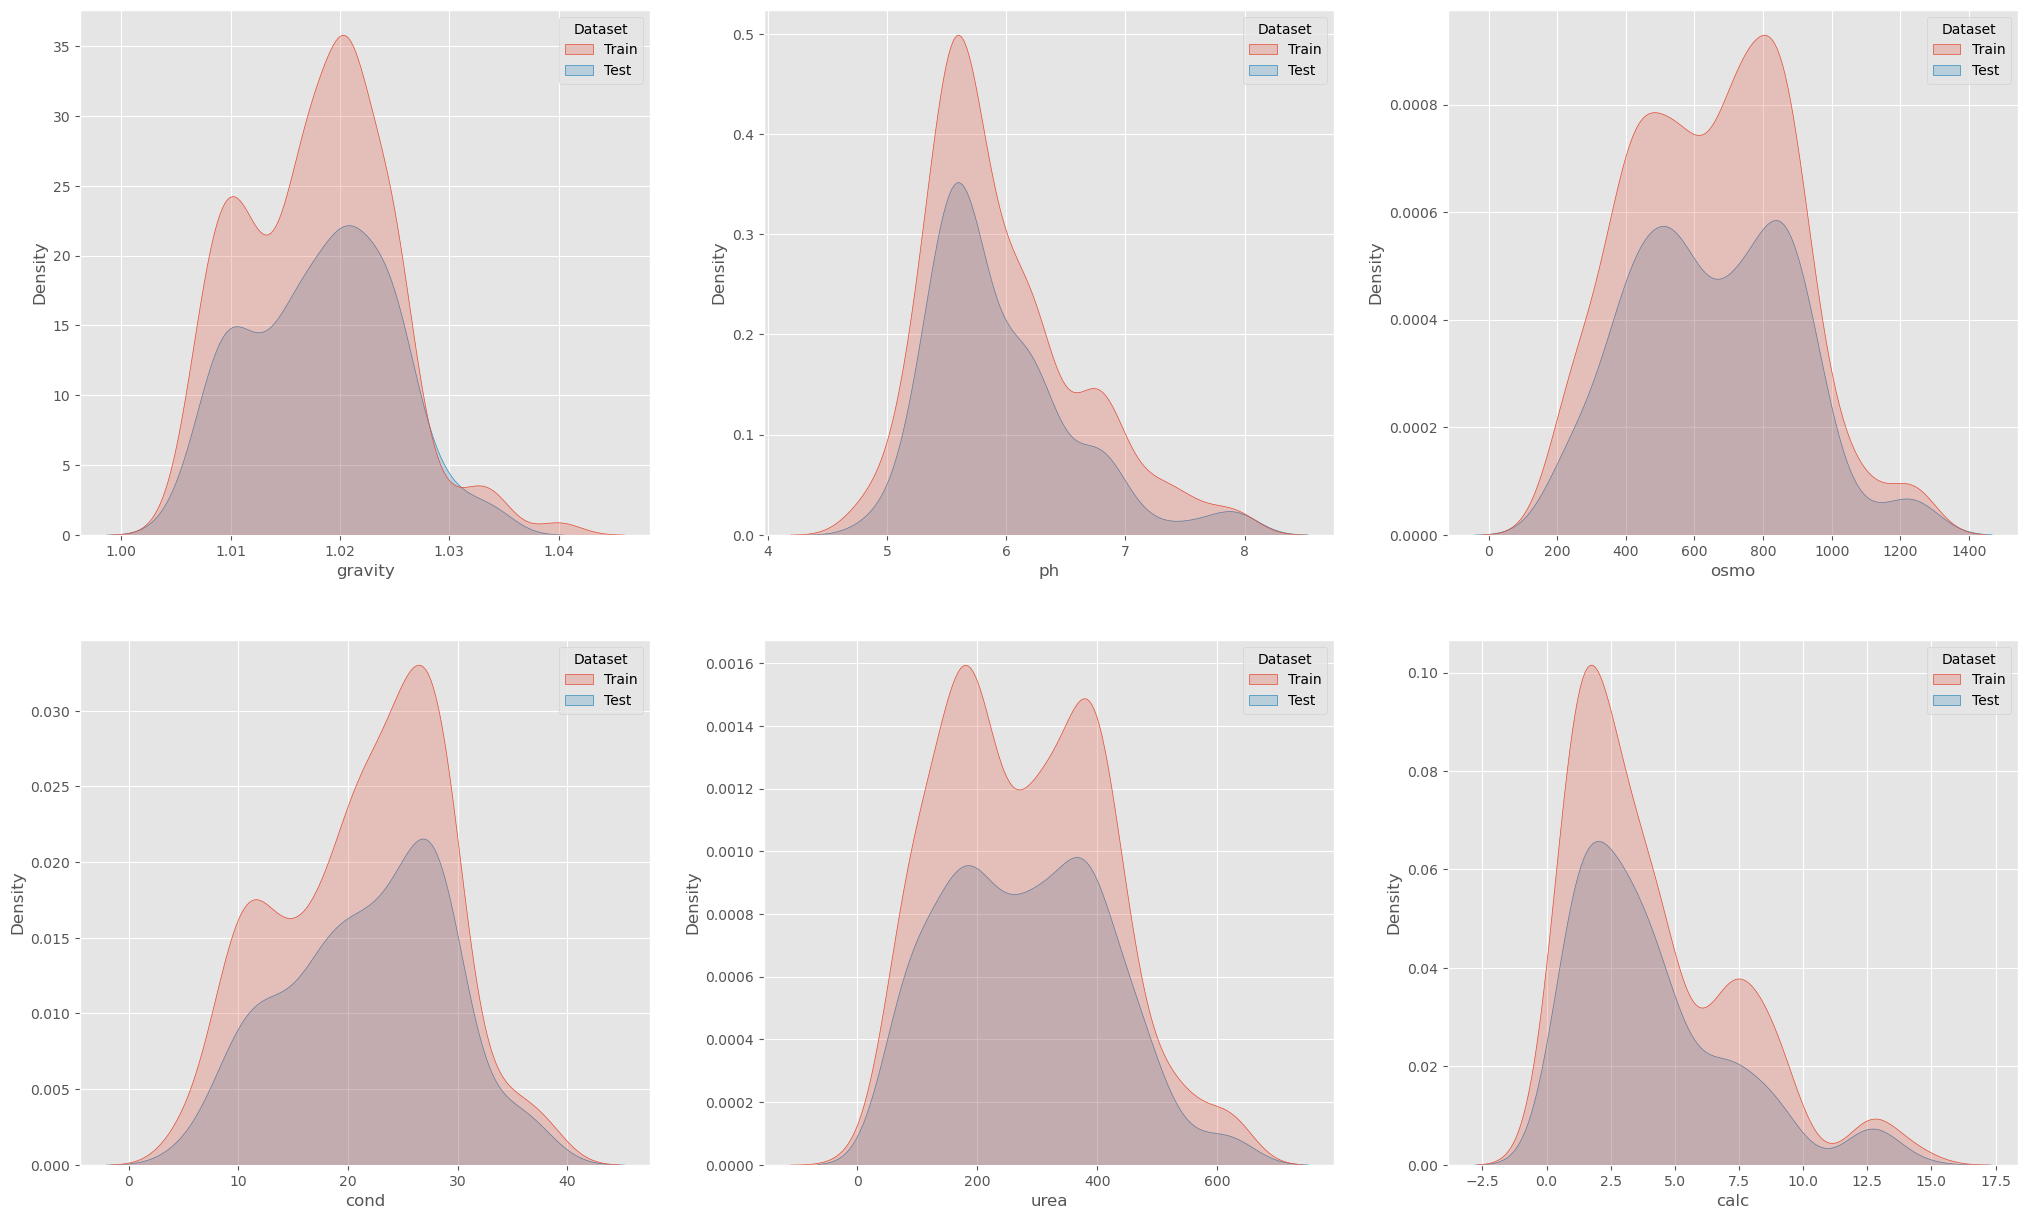

In [16]:
train_vis = train.drop(columns = ['id', 'target'], axis = 1).reset_index(drop = True).copy()
test_vis = test.drop(columns = ['id'], axis = 1).reset_index(drop = True).copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(2, 3, figsize = (25, 15))

sns.kdeplot(ax = axes[0, 0], x = 'gravity', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'ph', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'osmo', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'cond', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'urea', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'calc', hue = 'Dataset', data = data_tot, fill = True)

From the above density plots, we see that the distributions of the features are very similar in the train and test datasets.

check for duplicates

In [17]:
print('There are ', train.shape[0], ' observations in the train datset')
print('There are ', train.drop(columns = ['id', 'target'], axis = 1).drop_duplicates().shape[0], ' unique observations in the train datset')

There are  414  observations in the train datset
There are  414  unique observations in the train datset


In [18]:
print('There are ', test.shape[0], ' observations in the test datset')
print('There are ', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], ' unique observations in the test datset')

There are  276  observations in the test datset
There are  276  unique observations in the test datset


In [19]:
print('There are ', test.shape[0], ' observations in the test datset')
print('There are ', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], ' unique observations in the test datset')

There are  276  observations in the test datset
There are  276  unique observations in the test datset


There are  0  rows that appear in the train and test dataset.

 proceed to explore the relationship of the features with the highest correlations.

<AxesSubplot:xlabel='urea', ylabel='gravity'>

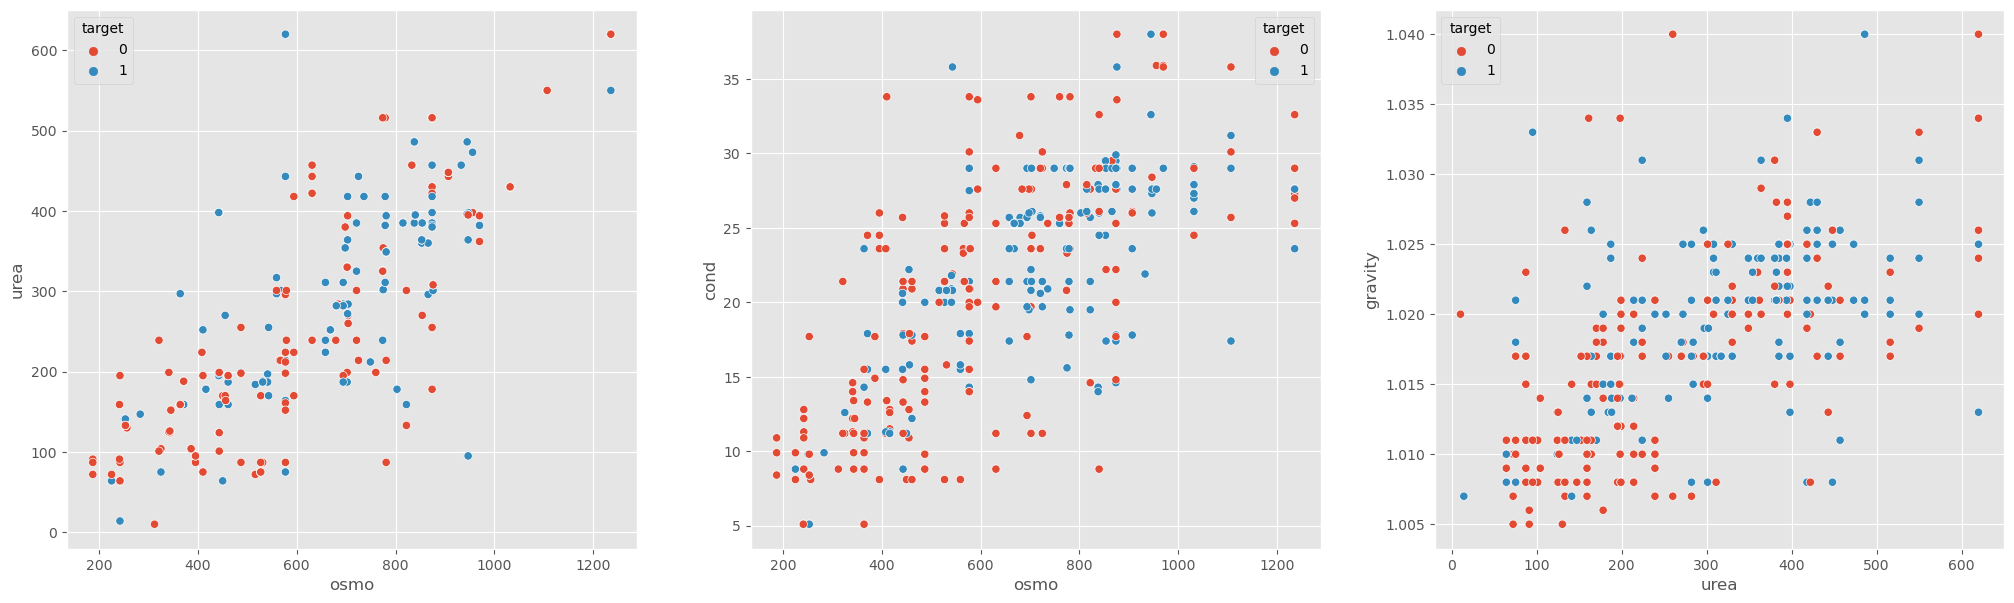

In [20]:
fig, axes = plt.subplots(1, 3, figsize = (25, 7))

sns.scatterplot(ax = axes[0], data = train, x = 'osmo', y = 'urea', hue = 'target')
sns.scatterplot(ax = axes[1], data = train, x = 'osmo', y = 'cond', hue = 'target')
sns.scatterplot(ax = axes[2], data = train, x = 'urea', y = 'gravity', hue = 'target')

From the above scatter-plots, we see that there is not a clear pattern

We had  see the different relation during EDA , we can pass to the model step( classification one)

## Modeling

### Logisitic Regression

In [21]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):
        
    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building logistic model
    model = LogisticRegression(penalty = 'l2',
                               C = 0.01, 
                               max_iter = 10000).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
logit_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Logistic Regression model over 10-folds is:', logit_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.6910755148741419
Fold 1 ==> roc-auc-score is ==> 0.7391304347826088
Fold 2 ==> roc-auc-score is ==> 0.7620137299771168
Fold 3 ==> roc-auc-score is ==> 0.8375286041189931
Fold 4 ==> roc-auc-score is ==> 0.8454106280193237
Fold 5 ==> roc-auc-score is ==> 0.785024154589372
Fold 6 ==> roc-auc-score is ==> 0.7801932367149758
Fold 7 ==> roc-auc-score is ==> 0.8067632850241546
Fold 8 ==> roc-auc-score is ==> 0.7342995169082125
Fold 9 ==> roc-auc-score is ==> 0.8236714975845411
The oof average roc-auc-score of the Logistic Regression model over 10-folds is: 0.780511060259344


plot the result : 

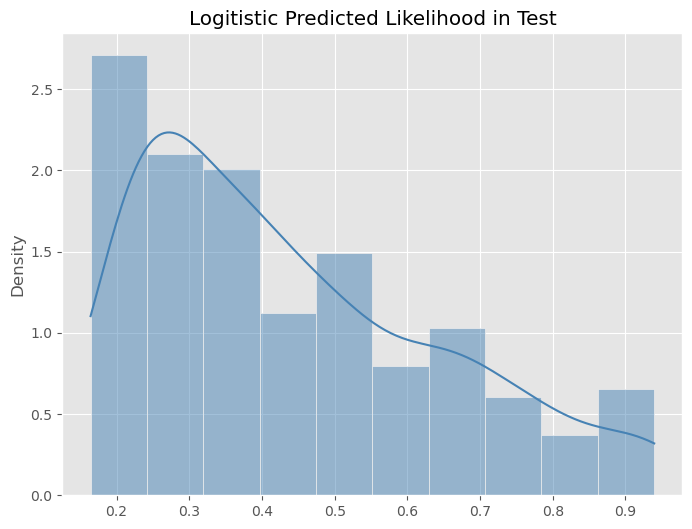

In [22]:
logit_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = logit_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Logitistic Predicted Likelihood in Test');

## Random Forest

In [23]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building RF model
    model = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 4,
                                   min_samples_split = 15,
                                   min_samples_leaf = 5,
                                   random_state = i).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
RF_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Random Forest model over 10-folds is:', RF_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7208237986270023
Fold 1 ==> roc-auc-score is ==> 0.6796338672768879
Fold 2 ==> roc-auc-score is ==> 0.782608695652174
Fold 3 ==> roc-auc-score is ==> 0.8215102974828375
Fold 4 ==> roc-auc-score is ==> 0.8405797101449275
Fold 5 ==> roc-auc-score is ==> 0.8188405797101449
Fold 6 ==> roc-auc-score is ==> 0.8333333333333333
Fold 7 ==> roc-auc-score is ==> 0.8454106280193237
Fold 8 ==> roc-auc-score is ==> 0.7777777777777778
Fold 9 ==> roc-auc-score is ==> 0.8623188405797102
The oof average roc-auc-score of the Random Forest model over 10-folds is: 0.7982837528604119


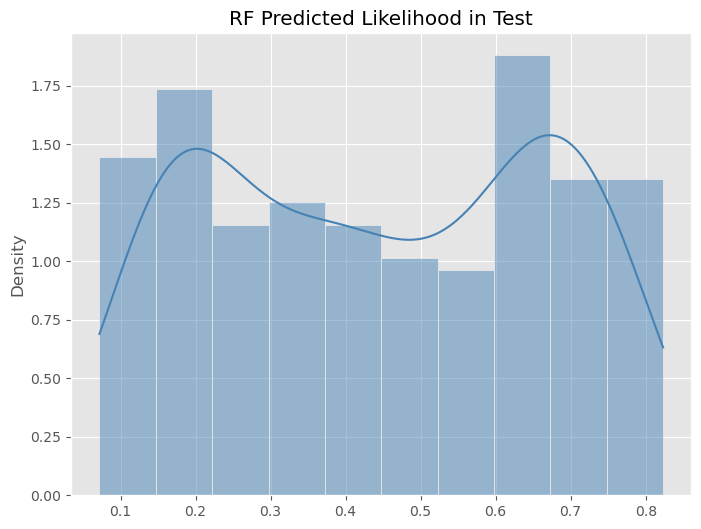

In [26]:


RF_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = RF_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'RF Predicted Likelihood in Test');



In [27]:
submission['target'] = RF_preds_test
submission.to_csv('RF_baseline_submission.csv', index = False)

## Extra Trees

In [28]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building ExtraTrees model
    model = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 4,
                                 min_samples_split = 15,
                                 min_samples_leaf = 5).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
extra_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Extra Trees model over 10-folds is:', extra_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7093821510297482
Fold 1 ==> roc-auc-score is ==> 0.6956521739130435
Fold 2 ==> roc-auc-score is ==> 0.7528604118993135
Fold 3 ==> roc-auc-score is ==> 0.8192219679633868
Fold 4 ==> roc-auc-score is ==> 0.8478260869565217
Fold 5 ==> roc-auc-score is ==> 0.7874396135265701
Fold 6 ==> roc-auc-score is ==> 0.8357487922705313
Fold 7 ==> roc-auc-score is ==> 0.8019323671497585
Fold 8 ==> roc-auc-score is ==> 0.7560386473429951
Fold 9 ==> roc-auc-score is ==> 0.8357487922705313
The oof average roc-auc-score of the Extra Trees model over 10-folds is: 0.78418510043224


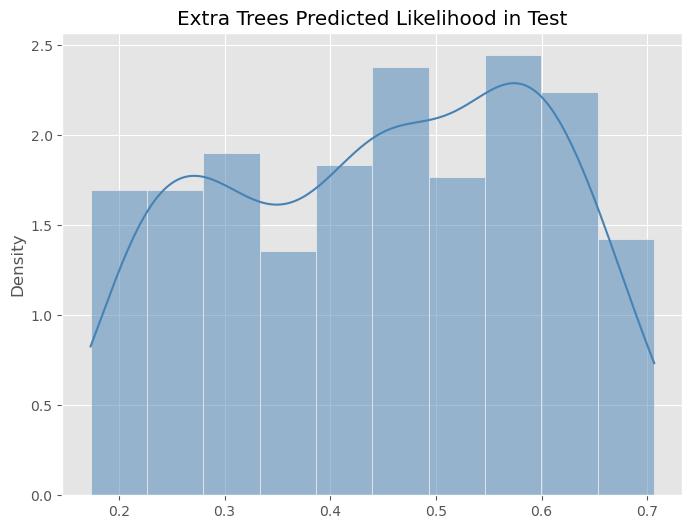

In [29]:


extra_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = extra_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Extra Trees Predicted Likelihood in Test');



In [30]:
submission['target'] = extra_preds_test
submission.to_csv('extra_baseline_submission.csv', index = False)

### GradientBoosting

In [31]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building GradientBoosting model
    model = GradientBoostingClassifier(n_estimators = 500, 
                                       learning_rate = 0.01,
                                       max_depth = 4,
                                       min_samples_split = 15,
                                       min_samples_leaf = 5).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
gradient_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Gradient Boosting model over 10-folds is:', gradient_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7231121281464531
Fold 1 ==> roc-auc-score is ==> 0.7459954233409611
Fold 2 ==> roc-auc-score is ==> 0.7643020594965675
Fold 3 ==> roc-auc-score is ==> 0.8100686498855836
Fold 4 ==> roc-auc-score is ==> 0.8043478260869564
Fold 5 ==> roc-auc-score is ==> 0.8405797101449275
Fold 6 ==> roc-auc-score is ==> 0.8454106280193237
Fold 7 ==> roc-auc-score is ==> 0.821256038647343
Fold 8 ==> roc-auc-score is ==> 0.7753623188405797
Fold 9 ==> roc-auc-score is ==> 0.8188405797101449
The oof average roc-auc-score of the Gradient Boosting model over 10-folds is: 0.794927536231884


[Text(0.5, 1.0, 'Gradient Boosting Predicted Likelihood in Test')]

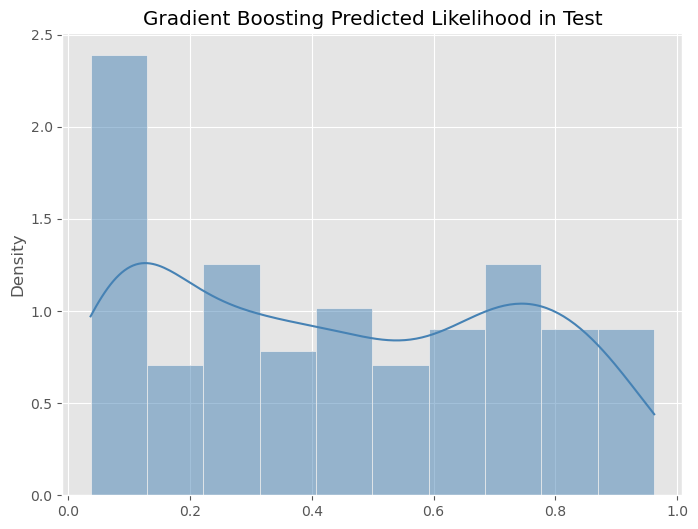

In [32]:


gradient_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = gradient_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Gradient Boosting Predicted Likelihood in Test')

In [33]:
submission['target'] = gradient_preds_test
submission.to_csv('gradient_baseline_submission.csv', index = False)

### HistGradientBoosting

In [34]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building HistGradient model
    model = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                           early_stopping = False,
                                           learning_rate = 0.01,
                                           max_iter = 500,
                                           max_depth = 3,
                                           max_bins = 255,
                                           min_samples_leaf = 5,
                                           max_leaf_nodes = 5).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
hist_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the HistGradient model over 10-folds is:', hist_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7048054919908466
Fold 1 ==> roc-auc-score is ==> 0.7322654462242563
Fold 2 ==> roc-auc-score is ==> 0.7414187643020594
Fold 3 ==> roc-auc-score is ==> 0.8192219679633866
Fold 4 ==> roc-auc-score is ==> 0.8043478260869565
Fold 5 ==> roc-auc-score is ==> 0.8091787439613526
Fold 6 ==> roc-auc-score is ==> 0.8091787439613527
Fold 7 ==> roc-auc-score is ==> 0.8429951690821256
Fold 8 ==> roc-auc-score is ==> 0.78743961352657
Fold 9 ==> roc-auc-score is ==> 0.8381642512077294
The oof average roc-auc-score of the HistGradient model over 10-folds is: 0.7889016018306636


[Text(0.5, 1.0, 'HistGradientBoosting Predicted Likelihood in Test')]

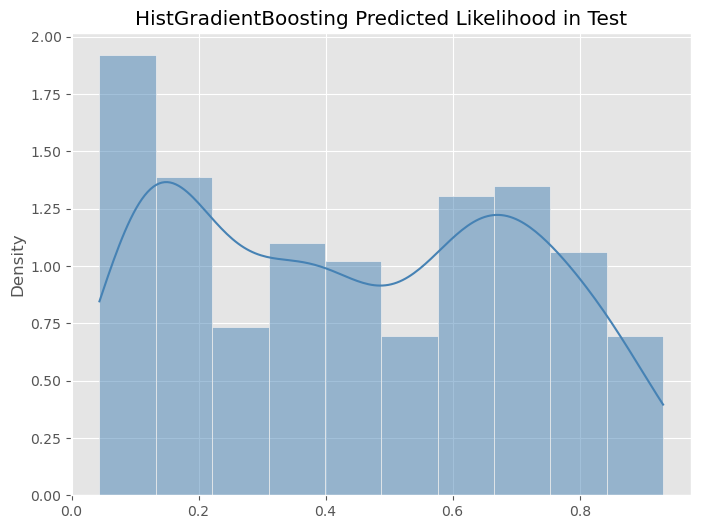

In [35]:
hist_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = hist_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'HistGradientBoosting Predicted Likelihood in Test')

In [36]:
submission['target'] = hist_preds_test
submission.to_csv('hist_baseline_submission.csv', index = False)

### LightGBM

In [37]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building LightGBM model
    model = LGBMClassifier(n_estimators = 500,
                           max_depth = 4,
                           learning_rate = 0.01,
                           num_leaves = 20,
                           reg_alpha = 3,
                           reg_lambda = 3,
                           subsample = 0.7,
                           colsample_bytree = 0.7).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
lgb_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the LightGBM model over 10-folds is:', lgb_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7048054919908467
Fold 1 ==> roc-auc-score is ==> 0.7322654462242563
Fold 2 ==> roc-auc-score is ==> 0.7551487414187643
Fold 3 ==> roc-auc-score is ==> 0.816933638443936
Fold 4 ==> roc-auc-score is ==> 0.7874396135265701
Fold 5 ==> roc-auc-score is ==> 0.8164251207729469
Fold 6 ==> roc-auc-score is ==> 0.8526570048309179
Fold 7 ==> roc-auc-score is ==> 0.8623188405797102
Fold 8 ==> roc-auc-score is ==> 0.7922705314009661
Fold 9 ==> roc-auc-score is ==> 0.8442028985507246
The oof average roc-auc-score of the LightGBM model over 10-folds is: 0.7964467327739639


[Text(0.5, 1.0, 'LightGBM Predicted Likelihood in Test')]

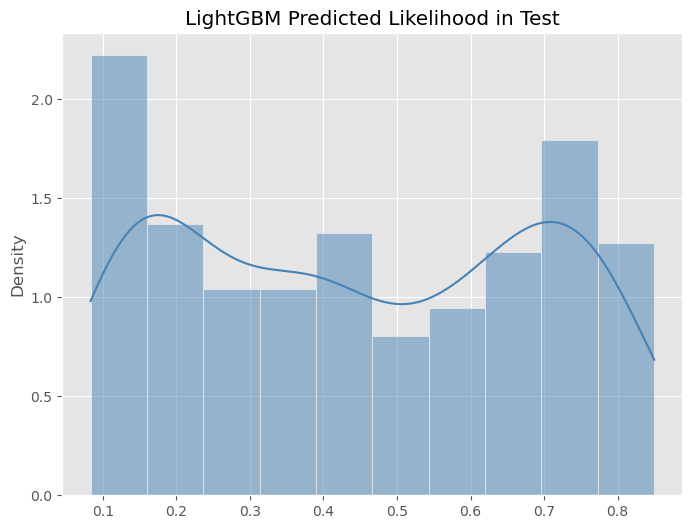

In [38]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = lgb_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'LightGBM Predicted Likelihood in Test')

In [39]:
submission['target'] = lgb_preds_test
submission.to_csv('lgb_baseline_submission.csv', index = False)

### XGBoost

In [40]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building XGBoost model
    model = XGBClassifier(tree_method = 'hist',
                          colsample_bytree = 0.7, 
                          gamma = 2, 
                          learning_rate = 0.01, 
                          max_depth = 4, 
                          min_child_weight = 10, 
                          n_estimators = 500, 
                          subsample = 0.7).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
xgb_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the XGBoost model over 10-folds is:', xgb_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7231121281464531
Fold 1 ==> roc-auc-score is ==> 0.7505720823798627
Fold 2 ==> roc-auc-score is ==> 0.7276887871853547
Fold 3 ==> roc-auc-score is ==> 0.8421052631578948
Fold 4 ==> roc-auc-score is ==> 0.8381642512077294
Fold 5 ==> roc-auc-score is ==> 0.7946859903381642
Fold 6 ==> roc-auc-score is ==> 0.8055555555555556
Fold 7 ==> roc-auc-score is ==> 0.861111111111111
Fold 8 ==> roc-auc-score is ==> 0.7729468599033816
Fold 9 ==> roc-auc-score is ==> 0.855072463768116
The oof average roc-auc-score of the XGBoost model over 10-folds is: 0.7971014492753623


[Text(0.5, 1.0, 'XGBoost Predicted Likelihood in Test')]

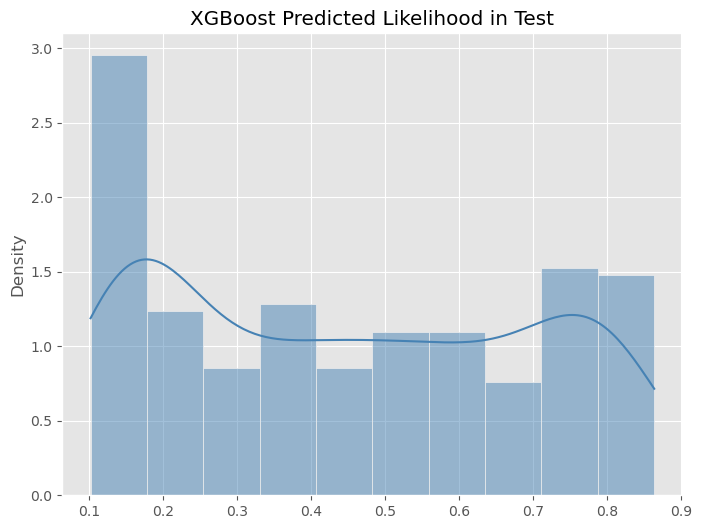

In [41]:
xgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = xgb_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'XGBoost Predicted Likelihood in Test')

In [42]:
submission['target'] = xgb_preds_test
submission.to_csv('xgb_baseline_submission.csv', index = False)

### CatBoost

In [43]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building XGBoost model
    model = CatBoostClassifier(loss_function = 'Logloss',
                               iterations = 500,
                               learning_rate = 0.01,
                               depth = 4,
                               random_strength = 0.5,
                               bagging_temperature = 0.7,
                               border_count = 30,
                               l2_leaf_reg = 5,
                               verbose = False, 
                               task_type = 'CPU').fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
cat_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the CatBoost model over 10-folds is:', cat_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7208237986270022
Fold 1 ==> roc-auc-score is ==> 0.6933638443935927
Fold 2 ==> roc-auc-score is ==> 0.7528604118993134
Fold 3 ==> roc-auc-score is ==> 0.8489702517162472
Fold 4 ==> roc-auc-score is ==> 0.8285024154589372
Fold 5 ==> roc-auc-score is ==> 0.8067632850241546
Fold 6 ==> roc-auc-score is ==> 0.8526570048309179
Fold 7 ==> roc-auc-score is ==> 0.8236714975845411
Fold 8 ==> roc-auc-score is ==> 0.7946859903381642
Fold 9 ==> roc-auc-score is ==> 0.8454106280193238
The oof average roc-auc-score of the CatBoost model over 10-folds is: 0.7967709127892195


[Text(0.5, 1.0, 'CatBoost Predicted Likelihood in Test')]

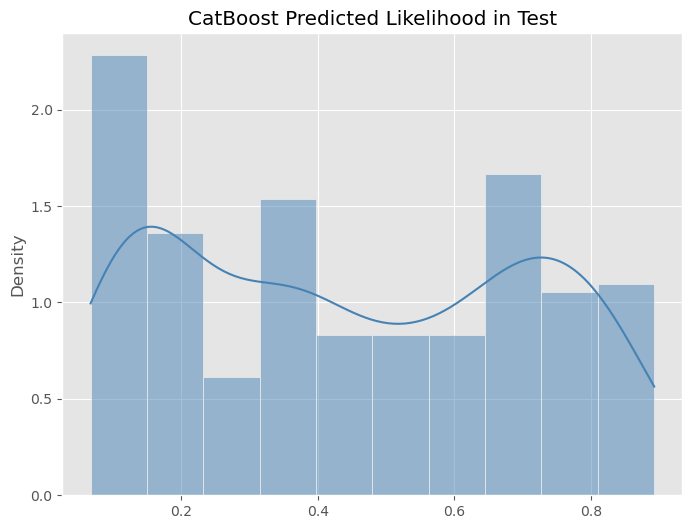

In [44]:
cat_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = cat_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'CatBoost Predicted Likelihood in Test')

In [45]:
submission['target'] = cat_preds_test
submission.to_csv('cat_baseline_submission.csv', index = False)

## Model Comparison

In [46]:
models_perf = pd.DataFrame({'Model': ['Logistic', 'RF', 'ExtraTrees', 'GradientBoosting', 'HistGradient', 'LightGBM', 'XGBoost', 'CatBoost'], 
                            'CV-Score': [logit_cv_score, RF_cv_score, extra_cv_score, gradient_cv_score, hist_cv_score, 
                                         lgb_cv_score, xgb_cv_score, cat_cv_score]})
models_perf

,Model,CV-Score
0,Logistic,0.780511
1,RF,0.798284
2,ExtraTrees,0.784185
3,GradientBoosting,0.794928
4,HistGradient,0.788902
5,LightGBM,0.796447
6,XGBoost,0.797101
7,CatBoost,0.796771


Text(0.5, 1.0, 'Correlations Among Model Predictions')

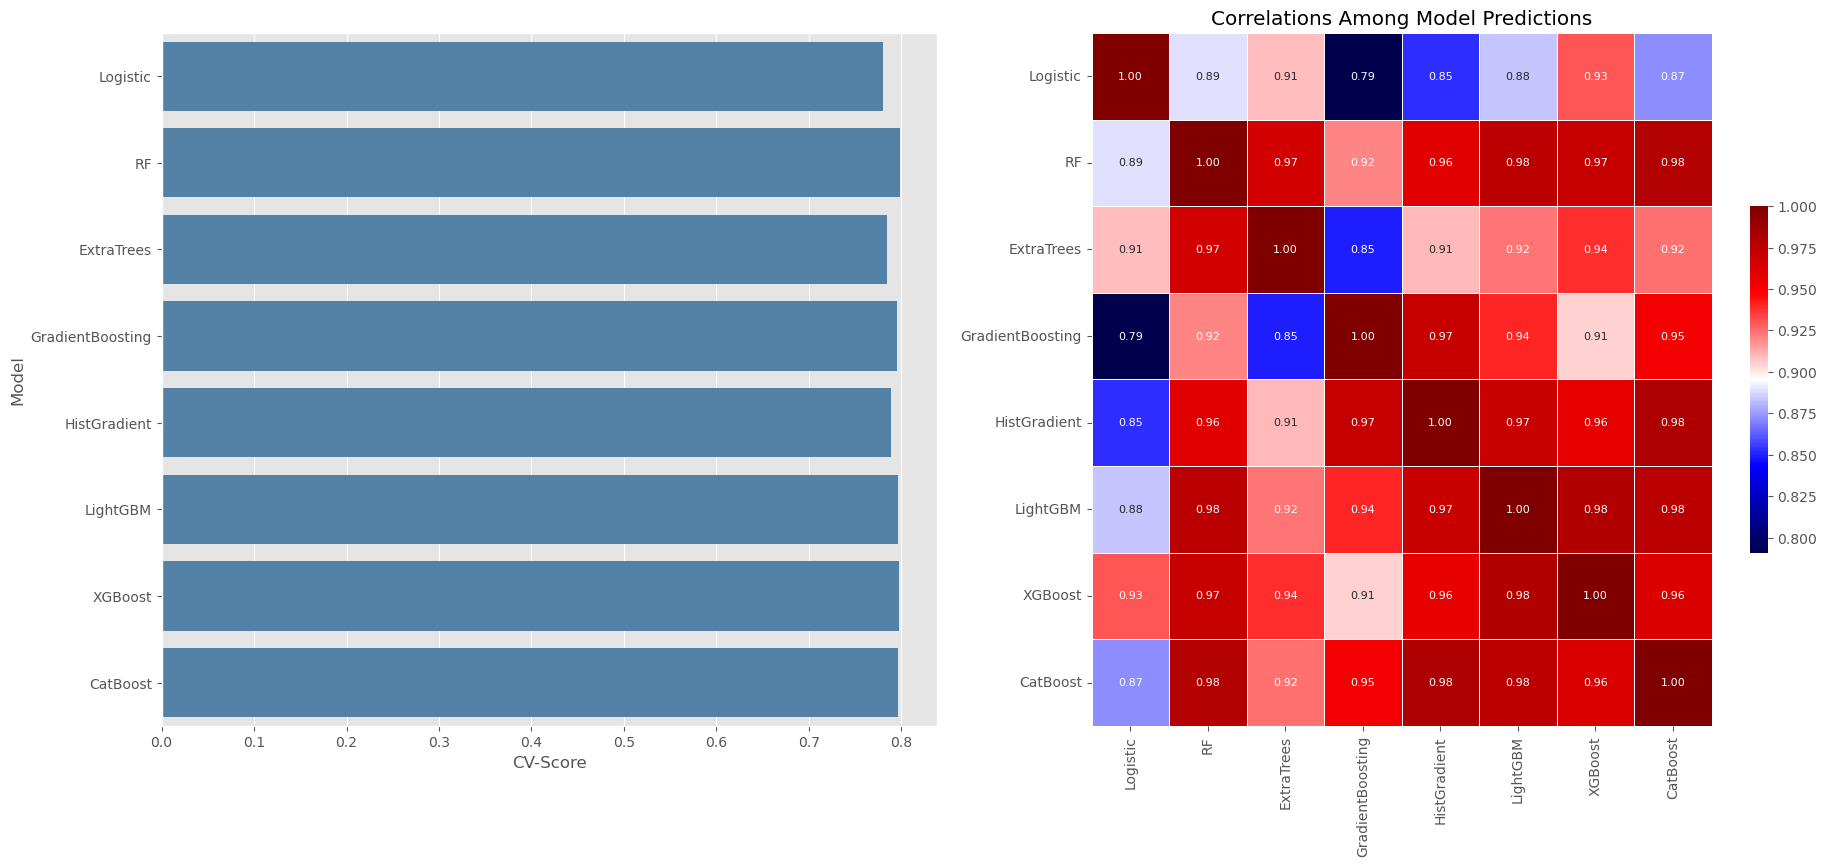

In [47]:
md_preds = pd.DataFrame({'Logistic': logit_preds_test,
                         'RF': RF_preds_test,
                         'ExtraTrees': extra_preds_test,
                         'GradientBoosting': gradient_preds_test,
                         'HistGradient': hist_preds_test,
                         'LightGBM': lgb_preds_test, 
                         'XGBoost': xgb_preds_test,
                         'CatBoost': cat_preds_test})
corr_mat_pred = md_preds.corr()

fig, axes = plt.subplots(1, 2, figsize = (22, 9))

sns.barplot(ax = axes[0], data = models_perf, x = 'CV-Score', y = 'Model', color = 'steelblue')
sns.heatmap(corr_mat_pred, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Model Predictions')

Lets make an ensemble learning to get the best of each 

[Text(0.5, 1.0, 'Ensemble Predicted Likelihood in Test')]

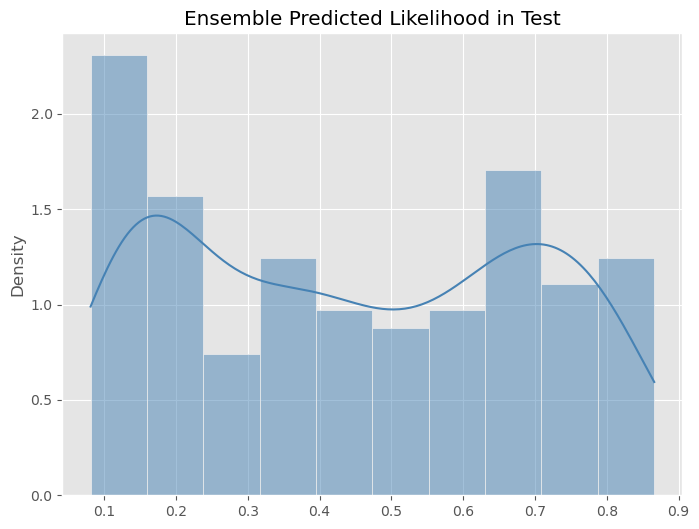

In [48]:
ens_preds_test = 0.25*RF_preds_test + 0.15*gradient_preds_test + 0.2*lgb_preds_test + 0.2*xgb_preds_test + 0.2*cat_preds_test

plt.figure(figsize = (8, 6))
sns.histplot(data = ens_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Ensemble Predicted Likelihood in Test')

In [49]:
submission['target'] = ens_preds_test
submission.to_csv('ensemble_baseline_submission.csv', index = False)

## Modeling the random forest

Random forest get the better result , lets look closer how optimize it

#### Taking a closer look at the partial dependency plots

In [50]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

model = RandomForestClassifier(n_estimators = 500, 
                               max_depth = 4,
                               min_samples_split = 15,
                               min_samples_leaf = 5).fit(X, Y)

fig, axs = plt.subplots(2, 3, figsize = (15, 10))
plt.suptitle('Partial Dependence Plots', y = 1.0)
PartialDependenceDisplay.from_estimator(model, X, X.columns.tolist(), 
                                        pd_line_kw = {"color": "red"},
                                        ice_lines_kw = {"color": "steelblue"},
                                        kind = 'both', 
                                        ax = axs.ravel()[:len(X.columns.tolist())])

plt.tight_layout(h_pad = 0.5, w_pad = 0.5)
plt.show()